## Imports

In [19]:
# Task 1 and 2
import csv
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Task 2 and 4
import scipy
import scipy.stats
from scipy.stats import chi2_contingency
import collections

# Task 3
import folium
from folium import plugins
from folium.plugins import HeatMap, MarkerCluster
import json
import shapely
from shapely.geometry import Point, MultiPoint, LineString, MultiLineString, Polygon, MultiPolygon

## Constants

In [ ]:
PATH = {}

PATH["data_raw"] = "../data/raw/"
PATH["data_interim"] = "../data/interim/"
PATH["data_processed"] = "../data/processed/"
PATH["data_external"] = "../data/external/"

FILENAME = {}
FILENAME["accidents"] = "Road Safety Data - Accidents 2019.csv"
FILENAME["casualties"] = "Road Safety Data - Casualties 2019.csv"
FILENAME["vehicles"] = "Road Safety Data- Vehicles 2019.csv" # Note the inconsistent naming of the raw data files

TABLENAMES = ["accidents", "casualties", "vehicles"]


In [ ]:
#Getting the data from the csv files,headerraw takes the label,done it this way to maintain 2d numpy array and not flatten it
dataraw_masked = {}
headerraw = {}
for tablename in TABLENAMES:
    headerraw[tablename]= np.genfromtxt(PATH["data_raw"] + FILENAME[tablename], delimiter = ',',encoding='utf-8-sig',dtype=str)[0,:]
    dataraw_masked[tablename] = np.genfromtxt(PATH["data_raw"] + FILENAME[tablename], delimiter = ',',encoding='utf-8-sig',dtype=None)[1:,:]
    

In [ ]:
#Printing the first 5 rows of the accidents to see how the data looks
dataraw_masked["accidents"][:5]


In [ ]:
#Creating the mask for the city of Liverpool, 91 is the code for the city of Liverpool

city_mask = [bool(x) for x in dataraw_masked["accidents"][:,np.where(headerraw["accidents"]=="Local_Authority_(District)")] == "91"] #Liverpool district
#creating the dataset of rows coresponding to the city of Liverpool for the accident circumstances
liverpoolRaw = dataraw_masked["accidents"][city_mask]
#Getting the accident index from the Liverpool dataset
ind = [x[0] for x in liverpoolRaw]

#Getting the data specific to Liverpool from the casualties and vehicles file
#by matching the accident index form the accidents file with the one from the other two 
data_casualties = dataraw_masked["casualties"][np.isin(dataraw_masked["casualties"][:,0], ind)]
data_vehicles = dataraw_masked["vehicles"][np.isin(dataraw_masked["vehicles"][:,0], ind)]

#The same accident index might appear multiple entries since they are reffering to different persons who were part of the accident

In [ ]:
#Exporting the liverpool dataset to an excel file
#No other cleaning has been done to this dataset ,because the missing values were given rid of by slicing the 2d numpy array when the figures are created
df_data_accidents_live = pd.DataFrame(liverpoolRaw,columns=headerraw["accidents"])
df_data_vehicles_liv = pd.DataFrame(data_vehicles,columns=headerraw["vehicles"])
df_data_casualty_liv=pd.DataFrame(data_casualties,columns=headerraw["casualties"])
filepath = PATH["data_processed"] + 'liverpool_dataset.xlsx'
writer = pd.ExcelWriter(filepath, engine = 'xlsxwriter')

df_data_accidents_live.to_excel(writer,sheet_name='accidents_liverpool', index=False)
df_data_vehicles_liv.to_excel(writer,sheet_name='vehicles_liverpool', index=False)
df_data_casualty_liv.to_excel(writer,sheet_name='casualties_liverpool', index=False)
writer.save()

Exploring the dataset using df.info() function

In [ ]:
df_data_accidents_live.info()
print()
df_data_vehicles_liv.info()
print()
df_data_casualty_liv.info()
#At first it can be seen that dataset is pretty clean and that each attributes does not seem to miss values
#all variables are of type object

# Task 1 

Creating a mask that doens't take into consideration the missing data, in this case the missing date correspond to "-1" values

In [20]:
mask = [bool(x) for x in data_vehicles[:,np.where(headerraw["vehicles"]=="Age_Band_of_Driver")] > "-1"]
data_vehicles_clear = data_vehicles[mask]

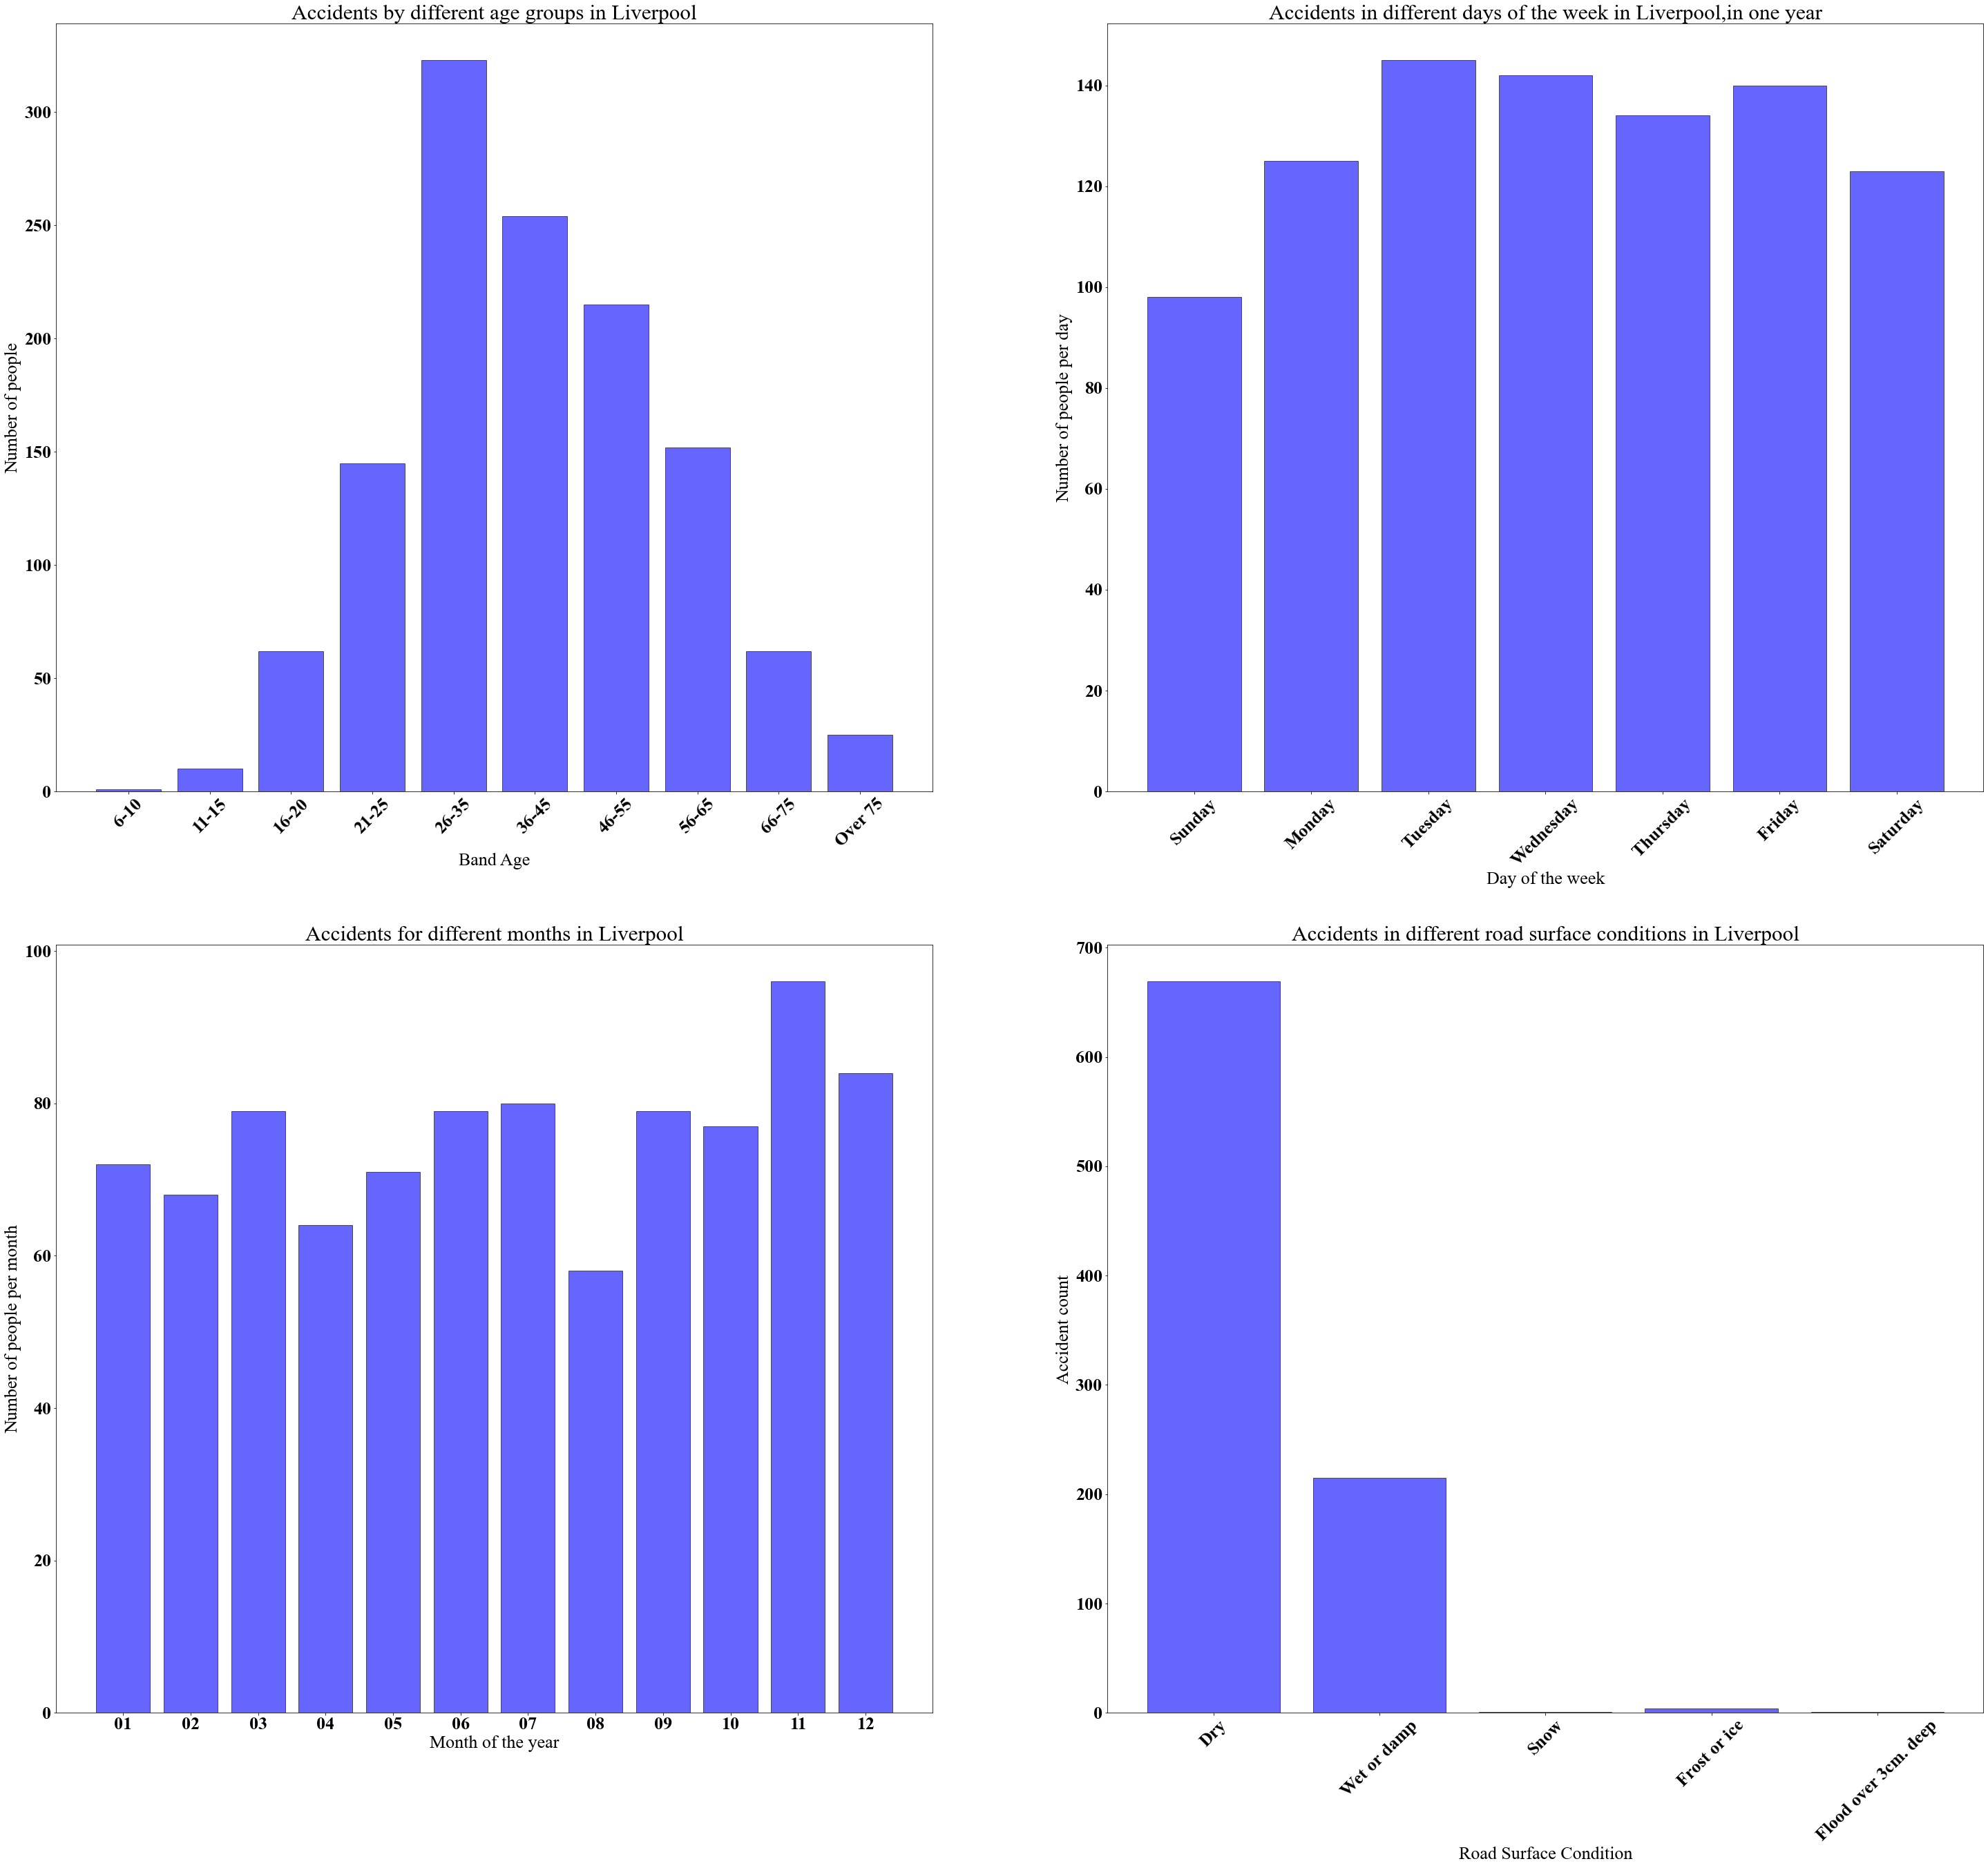

In [21]:
band_age_of_casualties = {2: "6-10", 3: "11-15", 4: "16-20", 5: "21-25", 6: "26-35", 7: "36-45", 8: "46-55", 9: "56-65", 10: "66-75", 11: "Over 75"}

#Getting the categories and counts for the age band of driver
categories_age, counts_age = np.unique(data_vehicles_clear[:,np.where(headerraw["vehicles"]=="Age_Band_of_Driver")], return_counts=True)

#need to do this because np.unique does not preserve the inital order
categories_age=np.concatenate((categories_age[2:],categories_age[:2]))
counts_age= np.concatenate((counts_age[2:],counts_age[:2]))

####################################################################################################
day_of_the_week = {1: "Sunday",2: "Monday", 3: "Tuesday", 4: "Wednesday", 5: "Thursday", 6: "Friday", 7: "Saturday" }

#Getting the categories and counts for accidents in liverpool during different days of the week
categories_week_day, counts_week_day = np.unique(liverpoolRaw[:,np.where(headerraw["accidents"]=="Day_of_Week")], return_counts=True)
#############################################################################################
#the dates of the year are a numpy arayy of numpy arrays, with the multiple comprehension list it has been unpack,probably not the best way
dates_of_year =liverpoolRaw[:,np.where(headerraw["accidents"]=="Date")]
flat_list = [item for sublist in dates_of_year for item in sublist]
flat_list2 =[item for sublist in flat_list for item in sublist]

#Getting the month out of the date variable from the accident circumstances datasets
months = [x[3:5] for x in flat_list2]

categories_month, counts_month = np.unique(months, return_counts=True)
####################################################################################################

road_surface_categories = {1: "Dry", 2: "Wet or damp", 3: "Snow", 4: "Frost or ice", 5: "Flood over 3cm. deep"}

#Creating a mask so that the missing data are not taking into consideration
road_cond_clean_mask= [bool(x) for x in liverpoolRaw[:,np.where(headerraw["accidents"]=="Road_Surface_Conditions")]!="-1"]
road_cond_clean = liverpoolRaw[road_cond_clean_mask]

#Getting the categories and counts for accidents in liverpool for different road surface conditions
categories_road_cond, counts_road_cond = np.unique(road_cond_clean[:,np.where(headerraw["accidents"]=="Road_Surface_Conditions")], return_counts=True)

#Creating the figure which has 4 subplots

fig = plt.figure(num=None, figsize=(50, 45))
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 26}

plt.rc('font', **font)
plt.subplots_adjust( hspace=0.2)

# Draw first subplot using plt.subplot
plt.subplot(2, 2, 1)
av1= plt.bar(categories_age, counts_age, fc="b",alpha=0.6,edgecolor='black')

plt.xticks([str(x) for x in band_age_of_casualties.keys()],band_age_of_casualties.values(),rotation=45)
plt.title("Accidents by different age groups in Liverpool")
plt.ylabel('Number of people')
plt.xlabel('Band Age')

# Draw first subplot using plt.subplot
plt.subplot(2, 2, 2)
av1= plt.bar(categories_week_day, counts_week_day, fc="b",alpha=0.6,edgecolor='black')

plt.xticks([str(x) for x in day_of_the_week.keys()],day_of_the_week.values(),rotation=45)
plt.title("Accidents in different days of the week in Liverpool,in one year")
plt.ylabel('Number of people per day')
plt.xlabel('Day of the week')

# Draw first subplot using plt.subplot
plt.subplot(2, 2, 3)
av1= plt.bar(categories_month, counts_month, fc="b",alpha=0.6,edgecolor='black')

plt.title("Accidents for different months in Liverpool")
plt.ylabel('Number of people per month')
plt.xlabel('Month of the year')

# Draw first subplot using plt.subplot
plt.subplot(2, 2, 4)
av1= plt.bar(categories_road_cond, counts_road_cond, fc="b",alpha=0.6,edgecolor='black')

plt.xticks([str(x) for x in road_surface_categories.keys()],road_surface_categories.values(),rotation=45)
plt.title("Accidents in different road surface conditions in Liverpool")
plt.ylabel('Accident count')
plt.xlabel('Road Surface Condition')


plt.show()

# Task 2 

Day_of_Week          1   2   3   4   5   6   7
Age_Band_of_Driver                            
-1                  42  49  54  36  40  48  34
 2                   0   1   0   0   0   0   0
 3                   0   0   2   1   5   1   1
 4                   6   8  13  10   8   7  10
 5                  14  22  29  17  21  21  21
 6                  31  31  43  65  58  50  45
 7                  25  32  35  51  39  33  39
 8                  30  26  41  36  29  25  28
 9                  16  21  18  24  28  32  13
 10                  5  17   7  10   8   8   7
 11                  2   4   5   3   4   5   2
The p value is: 0.08270890666050852
The cramer V for the age band of driver and day of week : 0.09018558189691239


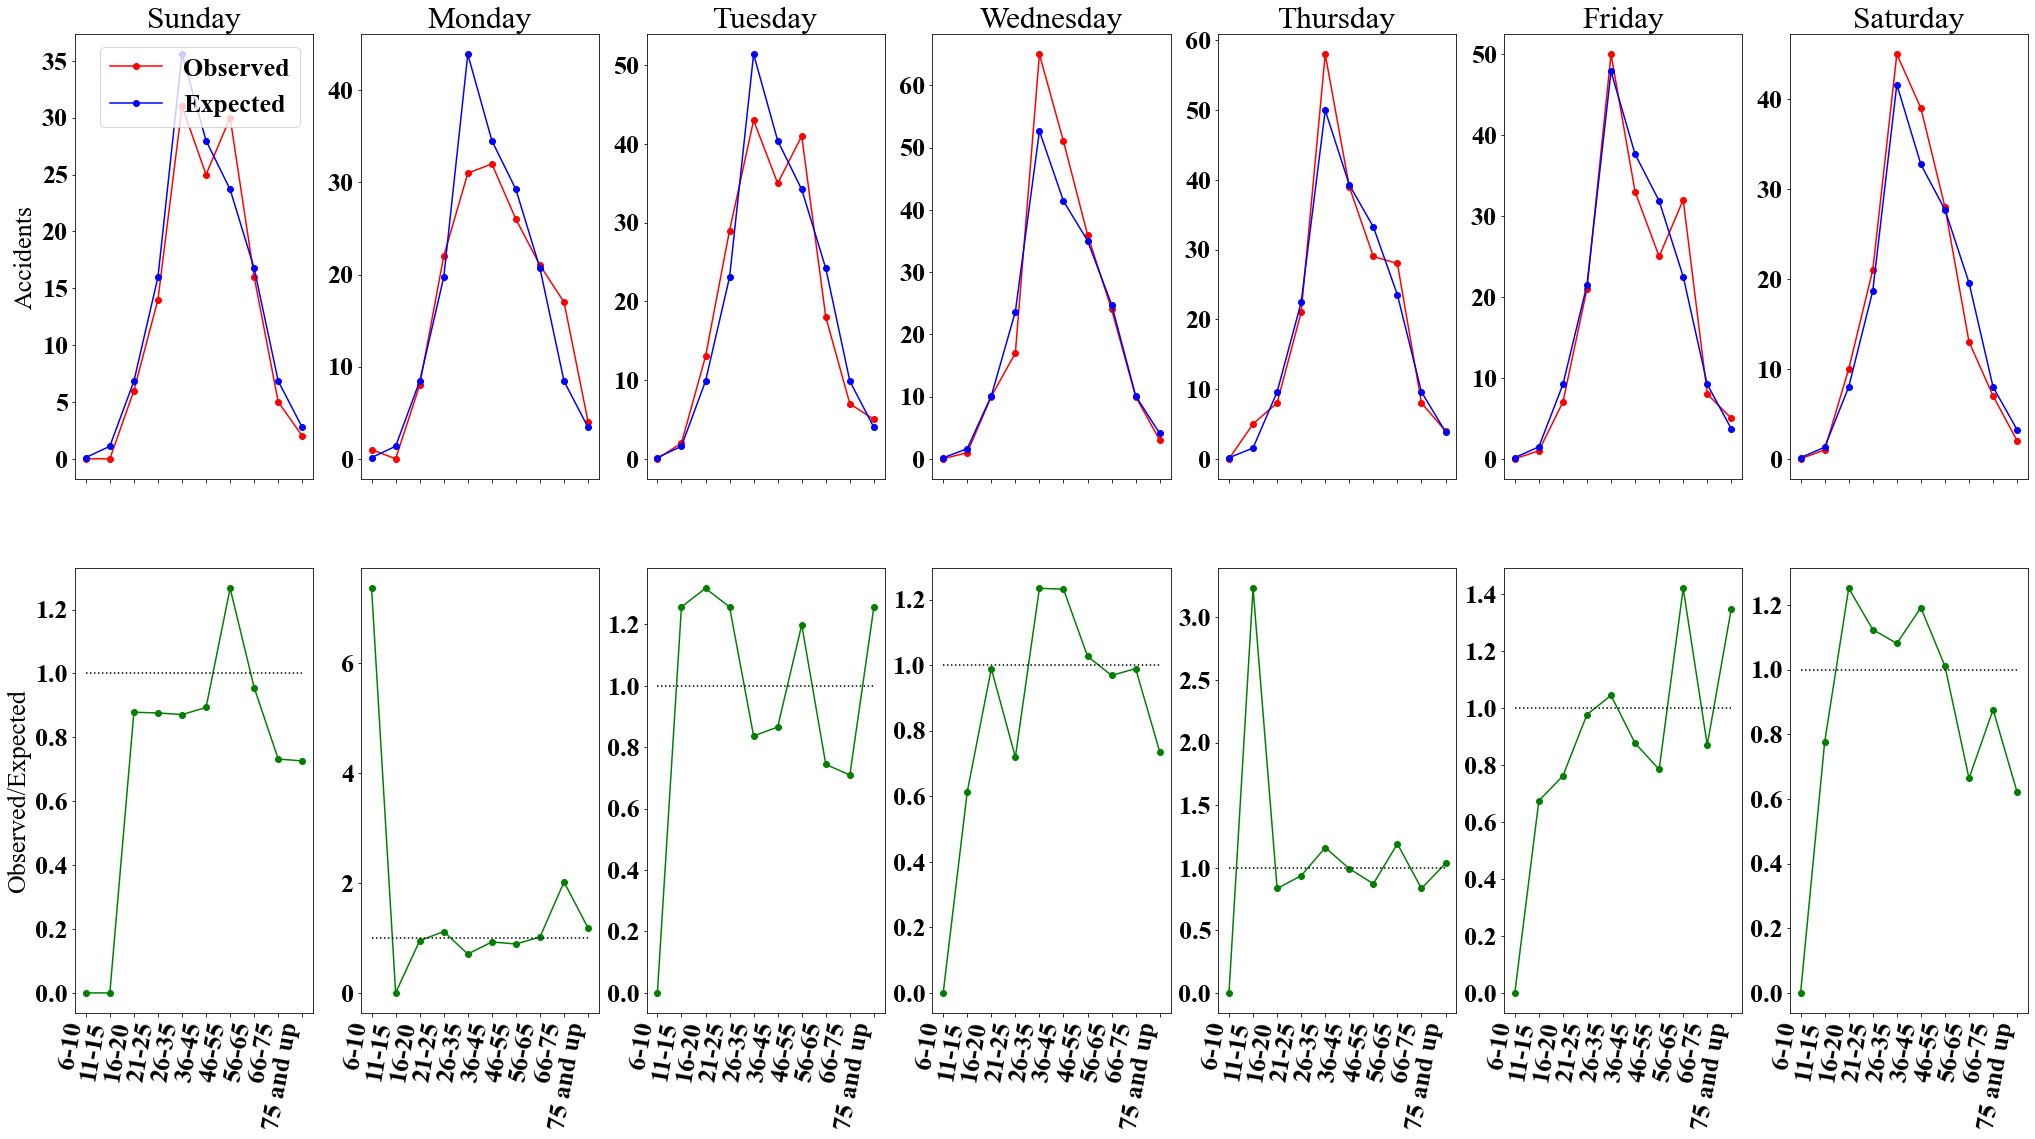

In [22]:
# Try to find association between Road Type and 1st Point of Impact,the code from here can be used for the second task

liverpoolRaw1 = liverpoolRaw

#Created a Counter which has data about how many time a accident_index is repeated in the vehicle dataset
accident_index_count= collections.Counter(data_vehicles[:,0])

#In this for, to the accident circumstances from liverpool dataset it is added some iddentical rows so that the shape of dataset is the same as the vehicle dataset
for i,x in enumerate(liverpoolRaw[:,0]):
    if(accident_index_count[x]!=1):
        liverpoolRaw1=np.append(liverpoolRaw1,np.tile(liverpoolRaw[i],(accident_index_count[x]-1,1)),axis=0)

#The array must be sorted by the index so that it matches the indexes from the vehicle dataset
sorted_live= liverpoolRaw1[liverpoolRaw1[:,0].argsort()]
###################################################################################################################

age_band_day_week = np.array([[int(x) for x in data_vehicles[:,np.where(headerraw["vehicles"]=="Age_Band_of_Driver")]],
                                [int(x) for x in sorted_live[:,np.where(headerraw["accidents"]=="Day_of_Week")]]]).T

observed_pd = pd.crosstab(age_band_day_week[:, 0], age_band_day_week[:, 1], rownames = ["Age_Band_of_Driver"], colnames = ["Day_of_Week"]) 
observed_as1 = observed_pd.to_numpy()
print(observed_pd)
rowTotals = observed_as1.sum(axis = 1) # R
N = rowTotals.sum()
chiVal_as1, pVal_as1, df_as1, expected_as1 = chi2_contingency(observed_as1)
chiVal_as1, pVal_as1, df_as1, expected_as1.astype(int)
print("The p value is:",pVal_as1)
V_as1 = np.sqrt( (chiVal_as1/N) / (min(observed_as1.shape)-1) )
print("The cramer V for the age band of driver and day of week :",V_as1)

fig, axes = plt.subplots(nrows=2, ncols=7, figsize=(35, 20))

weekday_labels = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
age_categories = {2: "6-10", 3: "11-15", 4: "16-20", 5: "21-25", 6: "26-35", 7: "36-45", 8: "46-55", 9: "56-65", 10: "66-75", 11: "75 and up"}

x = np.array(list(age_categories.keys()))
# print(observed[1:].shape)
for i, ax in enumerate(axes[0]):
    ax.plot(x, observed_as1[1:,i], 'ro-', label='Observed')
    ax.plot(x, expected_as1[1:,i], 'bo-', label='Expected')
    if i==0: 
        ax.set_ylabel('Accidents')
        ax.legend(loc='best');
    ax.set_title(weekday_labels[i])
    ax.set_xticks(x)
    ax.set_xticklabels(list(age_categories.values()))
    fig.autofmt_xdate(rotation=45)

for i, ax in enumerate(axes[1]):
    ax.plot(x, observed_as1[1:,i]/expected_as1[1:,i], 'go-')
    ax.plot(x, np.ones(x.shape), 'k:')
    
    if i==0: 
        ax.set_ylabel('Observed/Expected')
    ax.set_xticks(x)
    ax.set_xticklabels(list(age_categories.values()))
    fig.autofmt_xdate(rotation=80)
    

# Task 3

In [23]:
# We transform the array of tuples into a normal np.array.
acc_raw = []
for row in liverpoolRaw:
    r = [i for i in row]
    acc_raw.append(r)
acc_raw = np.array(acc_raw)
print("Length of the raw data for Liverpool:",len(acc_raw))

# We check if there are any empty cells in ouy array and print the row number.
print("\nThese rows have empty cells:")
for idx, row in enumerate(acc_raw):
    for i in row:
        if bool(i) == False:
            print(idx)

print("\nWe'll check what is missing in the rows:")            
print(acc_raw[591], "\n", acc_raw[730])

Length of the raw data for Liverpool: 907

These rows have empty cells:
591
730
730
730
730
730

We'll check what is missing in the rows:
['2019051912369' '336402' '387539' '-2.957546' '53.380871' '5' '3' '1' '1'
 '08/09/2019' '1' '' '91' 'E08000012' '6' '0' '6' '30' '3' '2' '3' '561'
 '0' '5' '4' '1' '1' '0' '0' '1' '1' 'E01032506'] 
 ['2019051912864' '' '' '' '' '5' '2' '2' '2' '08/11/2019' '6' '19:18' '91'
 'E08000012' '6' '0' '6' '30' '0' '-1' '-1' '0' '0' '0' '6' '1' '2' '0'
 '0' '3' '1' '']


In [25]:
# We can see that row 591 has an empty timestamp, this doenst matter for the visualization. 
# Row 730 has missing latitude and longtitude. 
# We make the array again, but skip row 730.
acc_cleaned = []
for idx, row in enumerate(liverpoolRaw):
    r = []
    for i in row:
        r.append(i)
    if idx != 730:
        acc_cleaned.append(r)
acc_cleaned = np.array(acc_cleaned)
print("Length of array after cleaning:",len(acc_cleaned))

Length of array after cleaning: 906


In [26]:
# Now we can create the two types of maps. 

latlons = np.vstack((acc_cleaned[:,4], acc_cleaned[:,3])).T
latlons = latlons.astype(np.float)

centroid = list(MultiPoint(latlons).centroid.coords)[0]

m1 = folium.Map(centroid, zoom_start=11)

for row in acc_cleaned:
    # The colors are changed according the severity of the accident.
    if int(row[6]) == 1:   col = "#000935"; # Fatal --> Black markers
    elif int(row[6]) == 2: col = "#4265ff"; # Serious --> Blue markers
    elif int(row[6]) == 3: col = "#90a4ff"; # Slight --> Light blue markers
    folium.CircleMarker([row[4], row[3]],
                        radius = 5,
                        popup = row[0] + "\n" + row[9] + ", " + row[11], #acc index, date, time
                        color = col,
                        legend_name="Severaty"
                       ).add_to(m1)
    
HeatMap(latlons).add_to(folium.FeatureGroup(name='Heat Map').add_to(m1))
folium.LayerControl().add_to(m1)
m1.save("../reports/figures/map1.html")
m1

In [27]:
# Map 2 with marker clusters, almost the same code as map 1. 

latlons = np.vstack((acc_cleaned[:,4], acc_cleaned[:,3])).T
latlons = latlons.astype(np.float)

centroid = list(MultiPoint(latlons).centroid.coords)[0]

m2 = folium.Map(centroid, zoom_start=11)

marker_cluster = MarkerCluster().add_to(folium.FeatureGroup(name='Clusters').add_to(m2))

for row in acc_cleaned:
    # The colors are changed according the severity of the accident.
    if int(row[6]) == 1:   col = "#000935"; # Fatal --> Black markers
    elif int(row[6]) == 2: col = "#4265ff"; # Serious --> Blue markers
    elif int(row[6]) == 3: col = "#90a4ff"; # Slight --> Light blue markers
    folium.CircleMarker([row[4], row[3]],
                        radius = 5,
                        popup = row[0] + "\n" + row[9] + ", " + row[11], #acc index, date, time
                        color = col,
                       ).add_to(marker_cluster)
    
HeatMap(latlons).add_to(folium.FeatureGroup(name='Heat Map').add_to(m2))
folium.LayerControl().add_to(m2)
m2.save("../reports/figures/map2.html")
m2

# Task 4

In [28]:

#create mask for fatalities on the liverpool dataset and create a numpy array with the rows which have an acident which is fatal
# accident severity 1:Fatal and 2:Serious
acc_sev_mask1a= [bool(x) for x in liverpoolRaw[:,np.where(headerraw["accidents"]=="Accident_Severity")]=="1"] 
acc1a= liverpoolRaw[acc_sev_mask1a]
acc_sev_mask2a= [bool(x) for x in liverpoolRaw[:,np.where(headerraw["accidents"]=="Accident_Severity")]=="2"]
acc2a= liverpoolRaw[acc_sev_mask2a]

road_types_cat = {1:"Roundabout",2:"One way street",3:"Dual carriageway",6:"Single carriageway" }

categories1a, counts1a = np.unique(acc1a[:,np.where(headerraw["accidents"]=="Road_Type")], return_counts=True)
categories2a, counts2a = np.unique(acc2a[:,np.where(headerraw["accidents"]=="Road_Type")], return_counts=True)
#resize the numpy array of fatalities counts so that it matches the size of counts of 
countx = np.pad(counts1a, ( counts2a.size-counts1a.size,0), 'constant')

#################################################################################################
#for all the data from the dataset
#Creating masks so that we get just the serious and fatal accidents
acc_sev_mask1b= [bool(x) for x in dataraw_masked["accidents"][:,np.where(headerraw["accidents"]=="Accident_Severity")]=="1"]
acc1b= dataraw_masked["accidents"][acc_sev_mask1b]
acc_sev_mask2b= [bool(x) for x in dataraw_masked["accidents"][:,np.where(headerraw["accidents"]=="Accident_Severity")]=="2"]
acc2b= dataraw_masked["accidents"][acc_sev_mask2b]

road_types_cat2 = {1:"Roundabout",2:"One way street",3:"Dual carriageway",6:"Single carriageway",7:"Slip road"}

categories1b, counts1b = np.unique(acc1b[:,np.where(headerraw["accidents"]=="Road_Type")], return_counts=True)
categories2b, counts2b = np.unique(acc2b[:,np.where(headerraw["accidents"]=="Road_Type")], return_counts=True)





In [29]:
#Try to found out if there is any association between Accident Severity and Road Type for Liverpool

liv_clean_data_mask1 = [bool(x) for x in liverpoolRaw[:,np.where(headerraw["accidents"]=="Accident_Severity")]<"3"]
liv_clean_data= liverpoolRaw[liv_clean_data_mask1]
road_type_acc_sev = np.array([[int(x) for x in liv_clean_data[:,np.where(headerraw["accidents"]=="Road_Type")]],
                          [int(x) for x in liv_clean_data[:,np.where(headerraw["accidents"]=="Accident_Severity")]]]).T


observed_pd_liv = pd.crosstab(road_type_acc_sev[:, 0], road_type_acc_sev[:, 1], rownames = ["Road_Type"], colnames = ["Accident Severity"]) 
observed_liv = observed_pd_liv.to_numpy()

rowTotals = observed_liv.sum(axis = 1) # R
N = rowTotals.sum()
chiVal, pVal, df, expected_liv = chi2_contingency(observed_liv)
chiVal, pVal, df, expected_liv.astype(int)
print("The p value for Liverpool is:",pVal)
V = np.sqrt( (chiVal/N) / (min(observed_liv.shape)-1) )
print("The cramer V for the road type and accidents severity for Liverpool:",V)
########################################################################################################
#Try to found out if there is any association between Accident Severity and Road Type for UK
#Trying to compare the p values and Cramer V values between Liverpool and the all UK
uk_clean_data_mask1 = [bool(x) for x in dataraw_masked["accidents"][:,np.where(headerraw["accidents"]=="Accident_Severity")]<"3"]
uk_clean_data= dataraw_masked["accidents"][uk_clean_data_mask1]
road_type_acc_sev_uk = np.array([[int(x) for x in uk_clean_data[:,np.where(headerraw["accidents"]=="Road_Type")]],
                          [int(x) for x in uk_clean_data[:,np.where(headerraw["accidents"]=="Accident_Severity")]]]).T


observed_pd_uk = pd.crosstab(road_type_acc_sev_uk[:, 0], road_type_acc_sev_uk[:, 1], rownames = ["Road_Type"], colnames = ["Accident Severity"]) 
observed_uk = observed_pd_uk.to_numpy()
observed_uk=observed_uk[:-2]
rowTotals = observed_uk.sum(axis = 1) # R
N = rowTotals.sum()
chiVal, pVal, df, expected_uk = chi2_contingency(observed_uk)
chiVal, pVal, df, expected_uk.astype(int)
print("The p value for all UK is:",pVal)
V = np.sqrt( (chiVal/N) / (min(observed_uk.shape)-1) )
print("The cramer V for the road type and accidents severity for all UK:",V)

The p value for Liverpool is: 0.6078015051800527
The cramer V for the road type and accidents severity for Liverpool: 0.10353126229075593
The p value for all UK is: 1.0239535040389411e-13
The cramer V for the road type and accidents severity for all UK: 0.05085270375098058


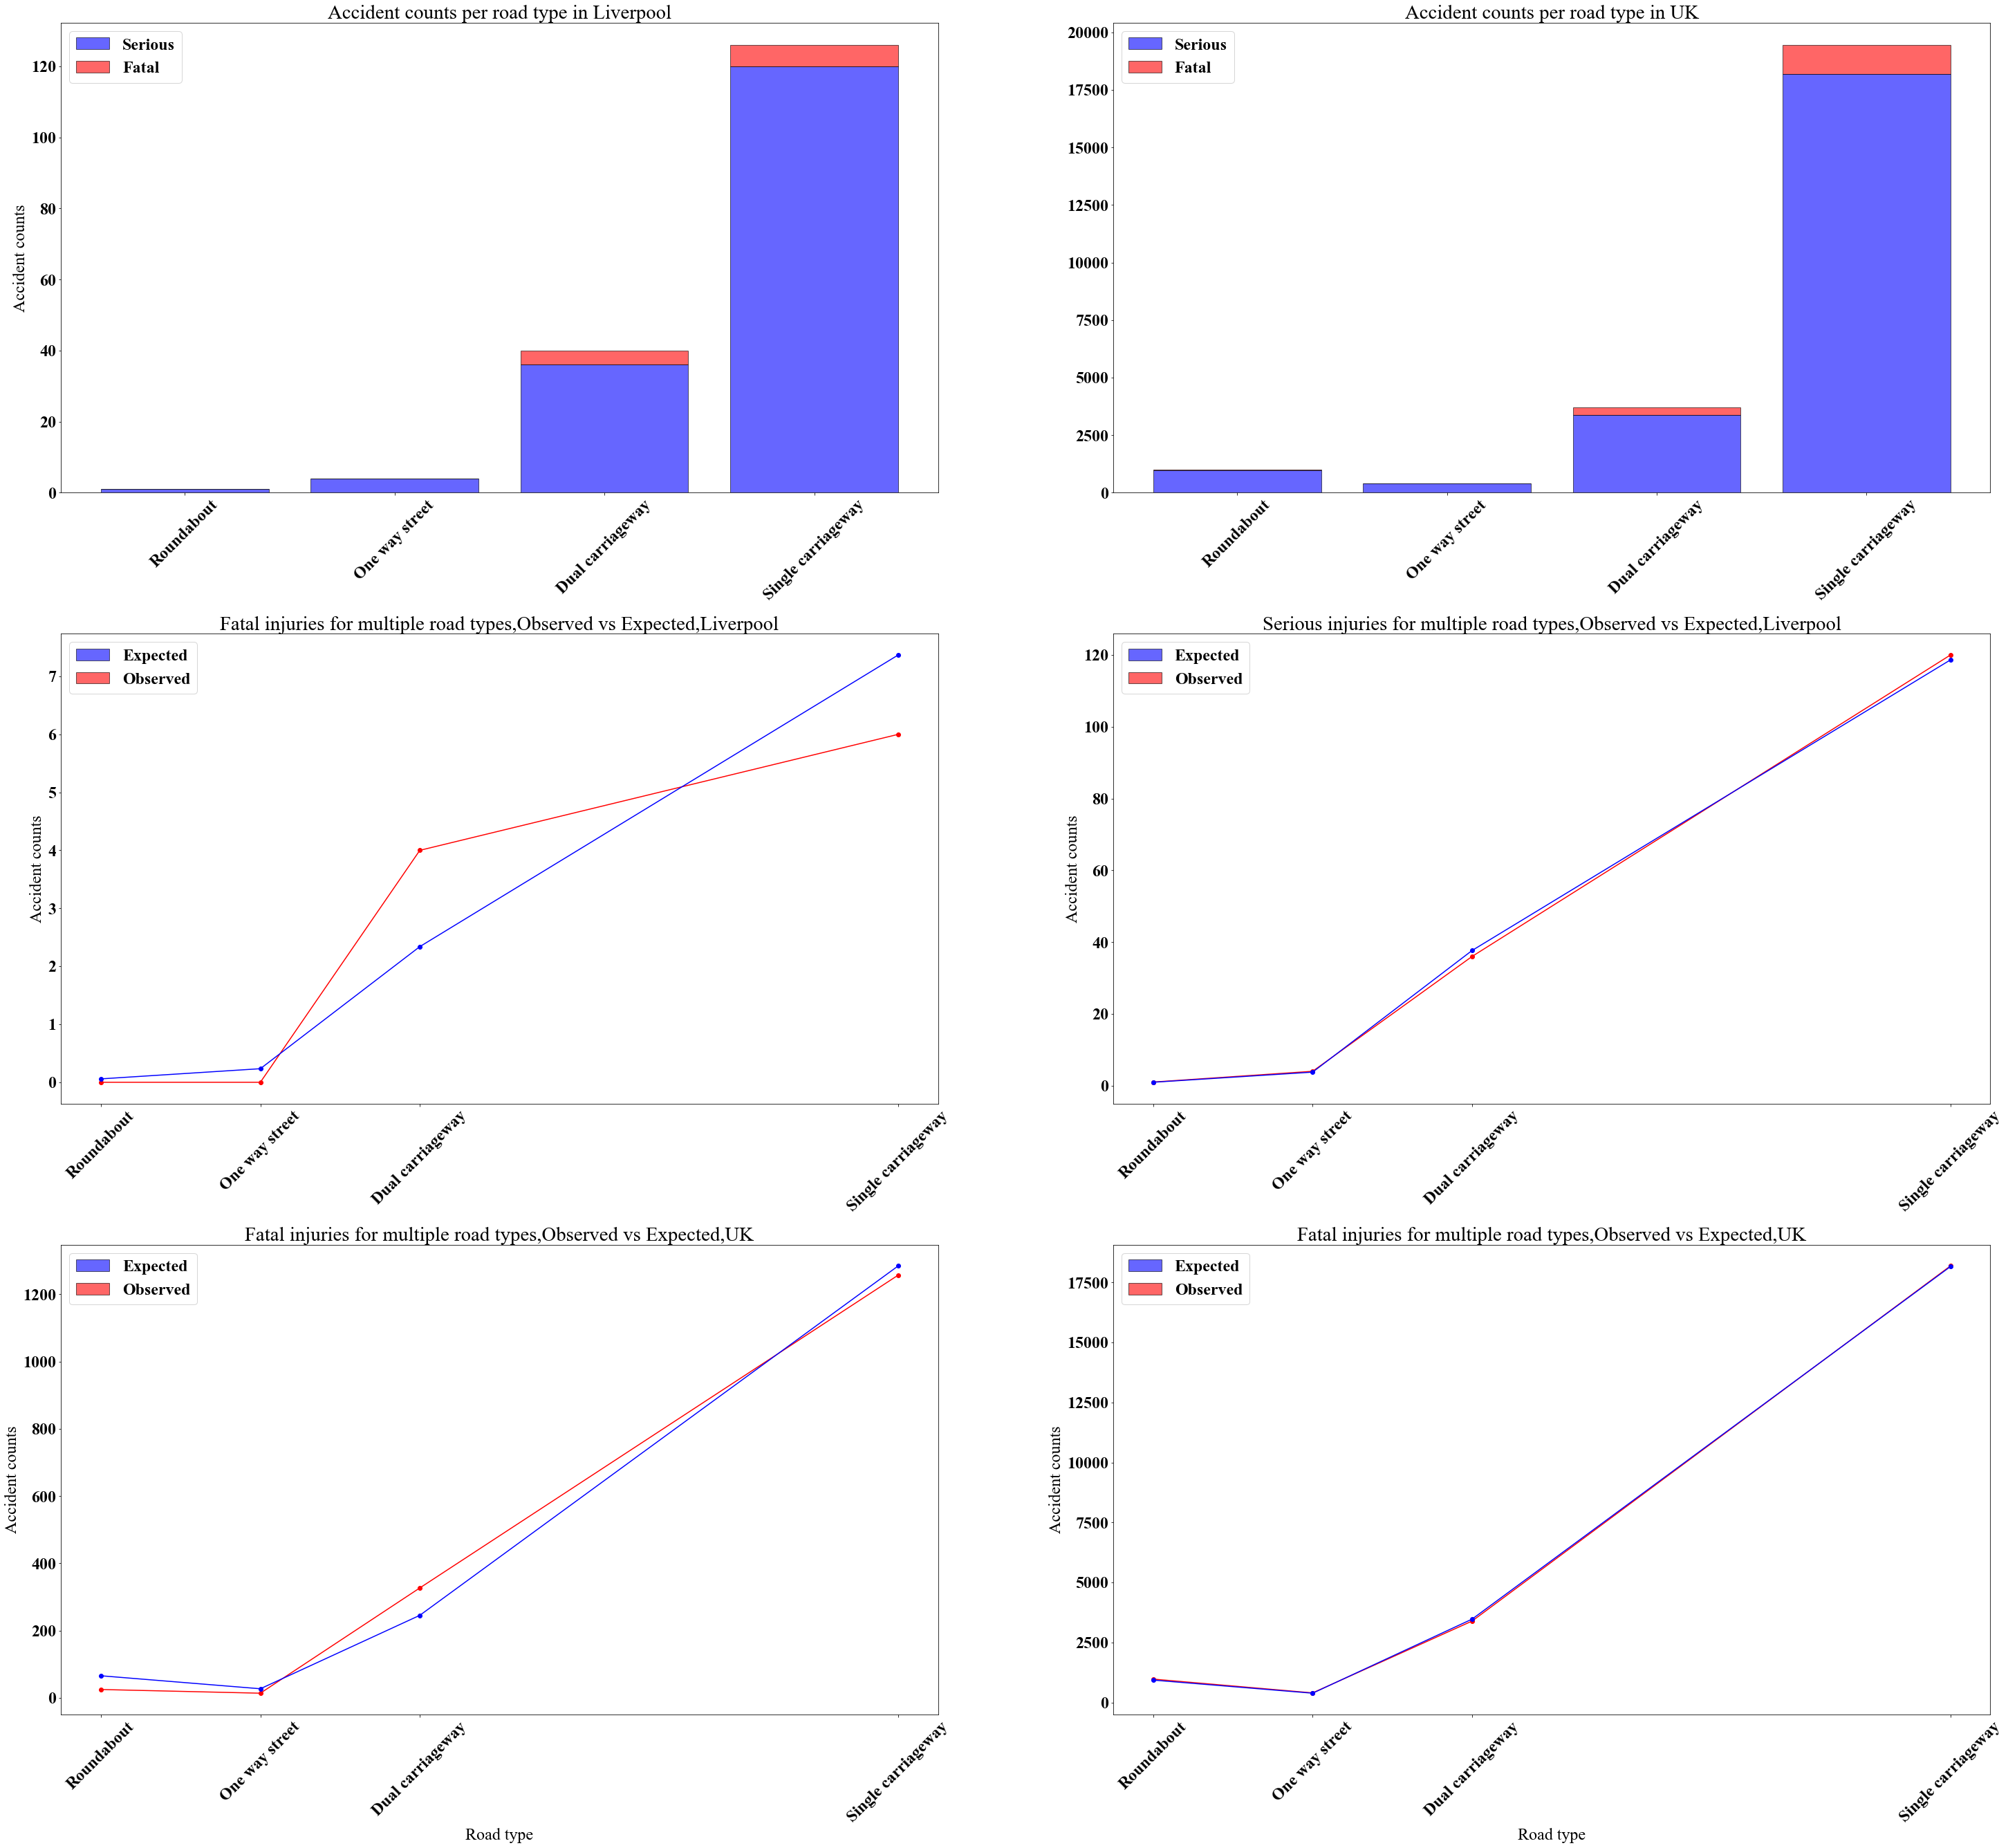

In [30]:
#Creating the figure with 6 different subplots
fig = plt.figure(num=None, figsize=(50, 45))
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 24}

plt.rc('font', **font)
plt.subplots_adjust( hspace=0.3)

# Draw first subplot using plt.subplot
plt.subplot(3, 2, 1)
av1= plt.bar(categories2a, counts2a, fc="b",alpha=0.6,edgecolor='black')
av2 =plt.bar(categories2a, countx,bottom=counts2a, fc="r",alpha=0.6,edgecolor='black')

plt.xticks([str(x) for x in road_types_cat.keys()],road_types_cat.values(),rotation=45)
plt.ylabel('Accident counts')
plt.title("Accident counts per road type in Liverpool")
plt.legend((av1[0], av2[0]), ('Serious', 'Fatal'))

# Draw second subplot using plt.subplot
#Slicing the counts and categories since unknown and slid road are not significant
plt.subplot(3, 2, 2)
plt.bar(categories1b[:-2],counts1b[:-2],bottom=counts2b[:-2], fc="r",alpha=0.6,edgecolor='black')
plt.bar(categories2b[:-2],counts2b[:-2], fc="b",alpha=0.6,edgecolor='black')
plt.xticks([str(x) for x in road_types_cat.keys()],road_types_cat.values(),rotation=45)

plt.legend((av1[0], av2[0]), ('Serious', 'Fatal'))
plt.title("Accident counts per road type in UK")


#For Liverpool
road_type_catx = np.array(list(road_types_cat.keys()))
plt.subplot(3, 2, 3)
plt.plot(road_type_catx, observed_liv[:,0], 'ro-', label='Observed')
plt.plot(road_type_catx, expected_liv[:,0], 'bo-', label='Expected')

plt.xticks(road_type_catx,road_types_cat.values(),rotation=45)
plt.legend((av1[0], av2[0]), ('Expected', 'Observed'))
plt.title("Fatal injuries for multiple road types,Observed vs Expected,Liverpool")
plt.ylabel('Accident counts')


#Draw 2
road_type_catx = np.array(list(road_types_cat.keys()))
plt.subplot(3, 2, 4)
plt.plot(road_type_catx, observed_liv[:,1], 'ro-', label='Observed')
plt.plot(road_type_catx, expected_liv[:,1], 'bo-', label='Expected')

plt.xticks(road_type_catx,road_types_cat.values(),rotation=45)
plt.legend((av1[0], av2[0]), ('Expected', 'Observed'))
plt.title("Serious injuries for multiple road types,Observed vs Expected,Liverpool")
plt.ylabel('Accident counts')



#For Uk
road_type_catx = np.array(list(road_types_cat.keys()))
plt.subplot(3, 2, 5)
plt.plot(road_type_catx, observed_uk[:,0], 'ro-', label='Observed')
plt.plot(road_type_catx, expected_uk[:,0], 'bo-', label='Expected')
# plt.plot(road_type_catx, observed_uk[:,0]/expected_uk[:,0], 'go-')
# plt.plot(road_type_catx, np.ones(road_type_catx.shape), 'k:')
plt.xticks(road_type_catx,road_types_cat.values(),rotation=45)
plt.legend((av1[0], av2[0]), ('Expected', 'Observed'))
plt.xlabel('Road type')
plt.title("Fatal injuries for multiple road types,Observed vs Expected,UK")
plt.ylabel('Accident counts')

road_type_catx = np.array(list(road_types_cat.keys()))
plt.subplot(3, 2, 6)
plt.plot(road_type_catx, observed_uk[:,1], 'ro-', label='Observed')
plt.plot(road_type_catx, expected_uk[:,1], 'bo-', label='Expected')
# plt.plot(road_type_catx, observed_uk[:,1]/expected_uk[:,1], 'go-')
# plt.plot(road_type_catx, np.ones(road_type_catx.shape), 'k:')
plt.xticks(road_type_catx,road_types_cat.values(),rotation=45)
plt.legend((av1[0], av2[0]), ('Expected', 'Observed'))
plt.xlabel('Road type')
plt.title("Fatal injuries for multiple road types,Observed vs Expected,UK")
plt.ylabel('Accident counts')
plt.show()